In [1]:
import pyart
import matplotlib.pyplot as plt
import os,glob
import numpy as np
import products
import sort_radar
from time import process_time
from pyhail import mesh_ppi


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/viper/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### EVALUATING SINGLE-POL PRODUCTS

Let's read the radar volume

In [2]:
radar = pyart.aux_io.read_gamic('data/R13557476_202212121640.hdf5')

Sort rays and perform the interpolation between rays and for all sweeps. This is only necessary if the number of rays between sweep is not constant as is the case of the Chapecó radar

In [3]:
sort_radar.main(radar)

Evaluate the VIL, ET, VILD and Waldvogel. These variables will be directly added to the radar object. The 0 °C isotherm height needed for evaluating Waldvogel is of approximately 4000 m.

Note: VIL may be a little slow in this case and the integration may take around 20 seconds. 

In [4]:
start_time = process_time()

products.calc_VIL(radar, 'corrected_reflectivity')
products.calc_ET(radar, 'corrected_reflectivity')
products.calc_VILD(radar, 'VIL', 'ET')
products.calc_WV(radar, H0c=4900.0)

print("--- %s seconds ---" % (process_time() - start_time))

--- 1.7161400000000002 seconds ---


Plot the results

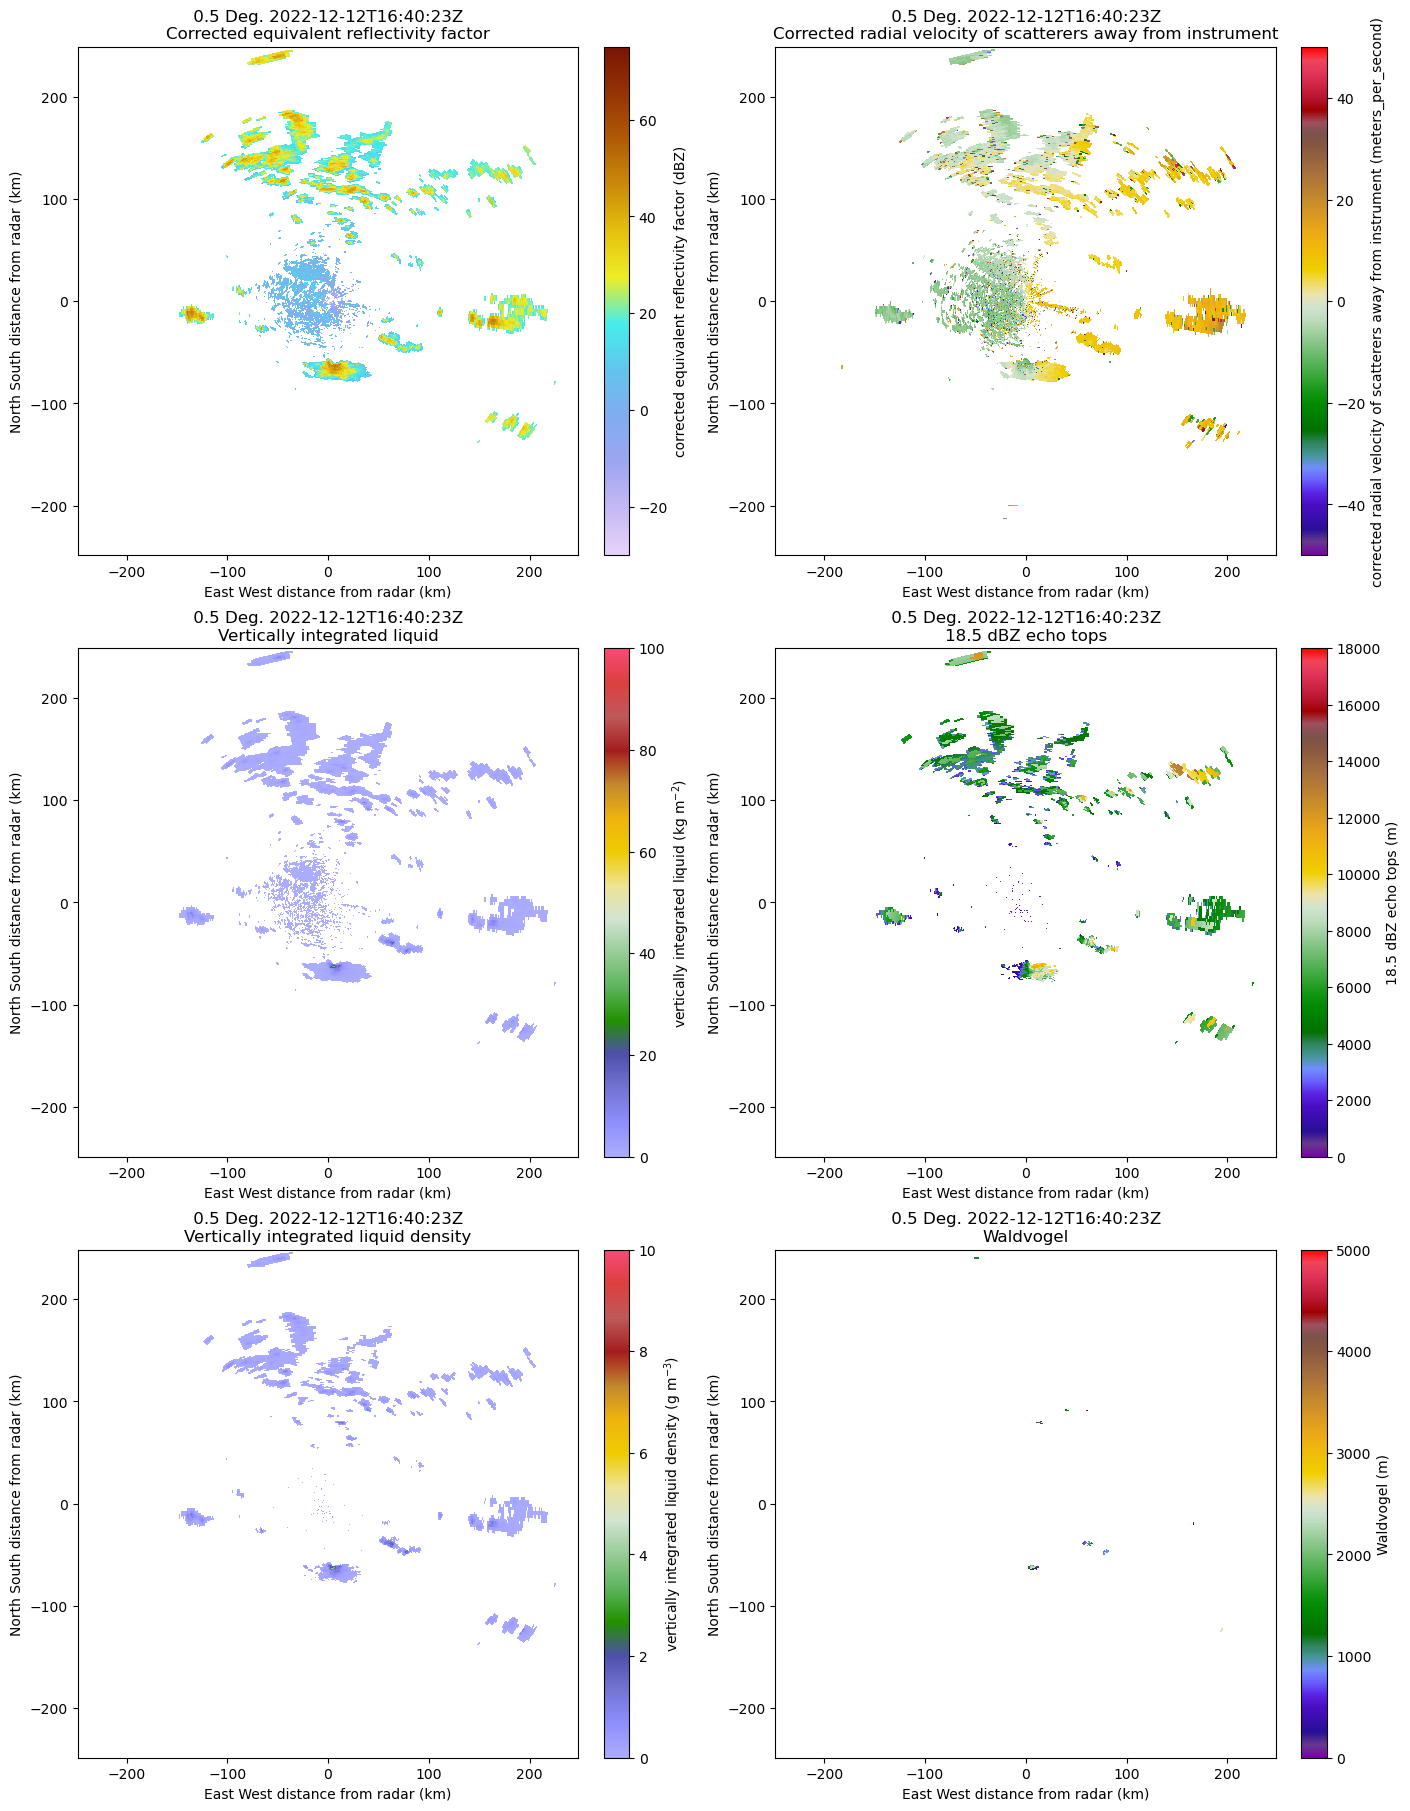

In [5]:
display = pyart.graph.RadarDisplay(radar)

fig, axs = plt.subplots(3, 2, figsize = [14, 18], constrained_layout = True)
display.plot_ppi('corrected_reflectivity', 0, cmap = pyart.graph.cm.LangRainbow12, ax = axs.ravel()[0])
display.plot_ppi('corrected_velocity', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[1])
display.plot_ppi('VIL', 0, vmin = 0, vmax=100, cmap = pyart.graph.cm.Theodore16, ax = axs.ravel()[2])
display.plot_ppi('ET', 0, vmin = 0, vmax=18000, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[3],)
display.plot_ppi('VILD', 0, vmin = 0, vmax = 10, cmap = pyart.graph.cm.Theodore16, ax = axs.ravel()[4])
display.plot_ppi('Waldvogel', 0, vmin = 0, vmax = 5000, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[5])

plt.savefig('/mnt/g/My Drive/DIPTC/relatório/legacy.jpg', dpi = 300, bbox_inches = 'tight')

We can also evaluate some hail products from PyHail such as hail Kinetic Energy (KE), Severe Hail Index (SHI), Probability of Severe Hail (POSH), Maximum Estimated Size of Hail (MESH).
In this case, we will use data from isolated supercells that produced a swath of hail damage during the May 30, 2019 severe weather outbreak. The data is from the São Roque single-pol radar.

In [14]:
radar = pyart.aux_io.read_gamic('data/R13537474_201905301000.hdf5')

Again, we need to sort the radar rays in order for the function to work

In [15]:
sort_radar.main(radar)

Let's evaluate the hail products

In [16]:
radar = mesh_ppi.main(radar, dbz_fname='corrected_reflectivity', levels = [4460.0, 7547.0], min_range = radar.range['data'][0], max_range=radar.range['data'][-1])

/home/viper/miniconda3/envs/py39/lib/python3.9/site-packages/pyhail/mesh_ppi.py:197: RuntimeWarning: divide by zero encountered in log
  POSH = 29 * np.log(SHI / WT) + 50


check for the fields' names 

In [17]:
radar.fields.keys()

dict_keys(['corrected_reflectivity', 'reflectivity', 'corrected_velocity', 'spectrum_width', 'hail_ke', 'shi', 'mesh_mh2019_95', 'posh'])

display the products

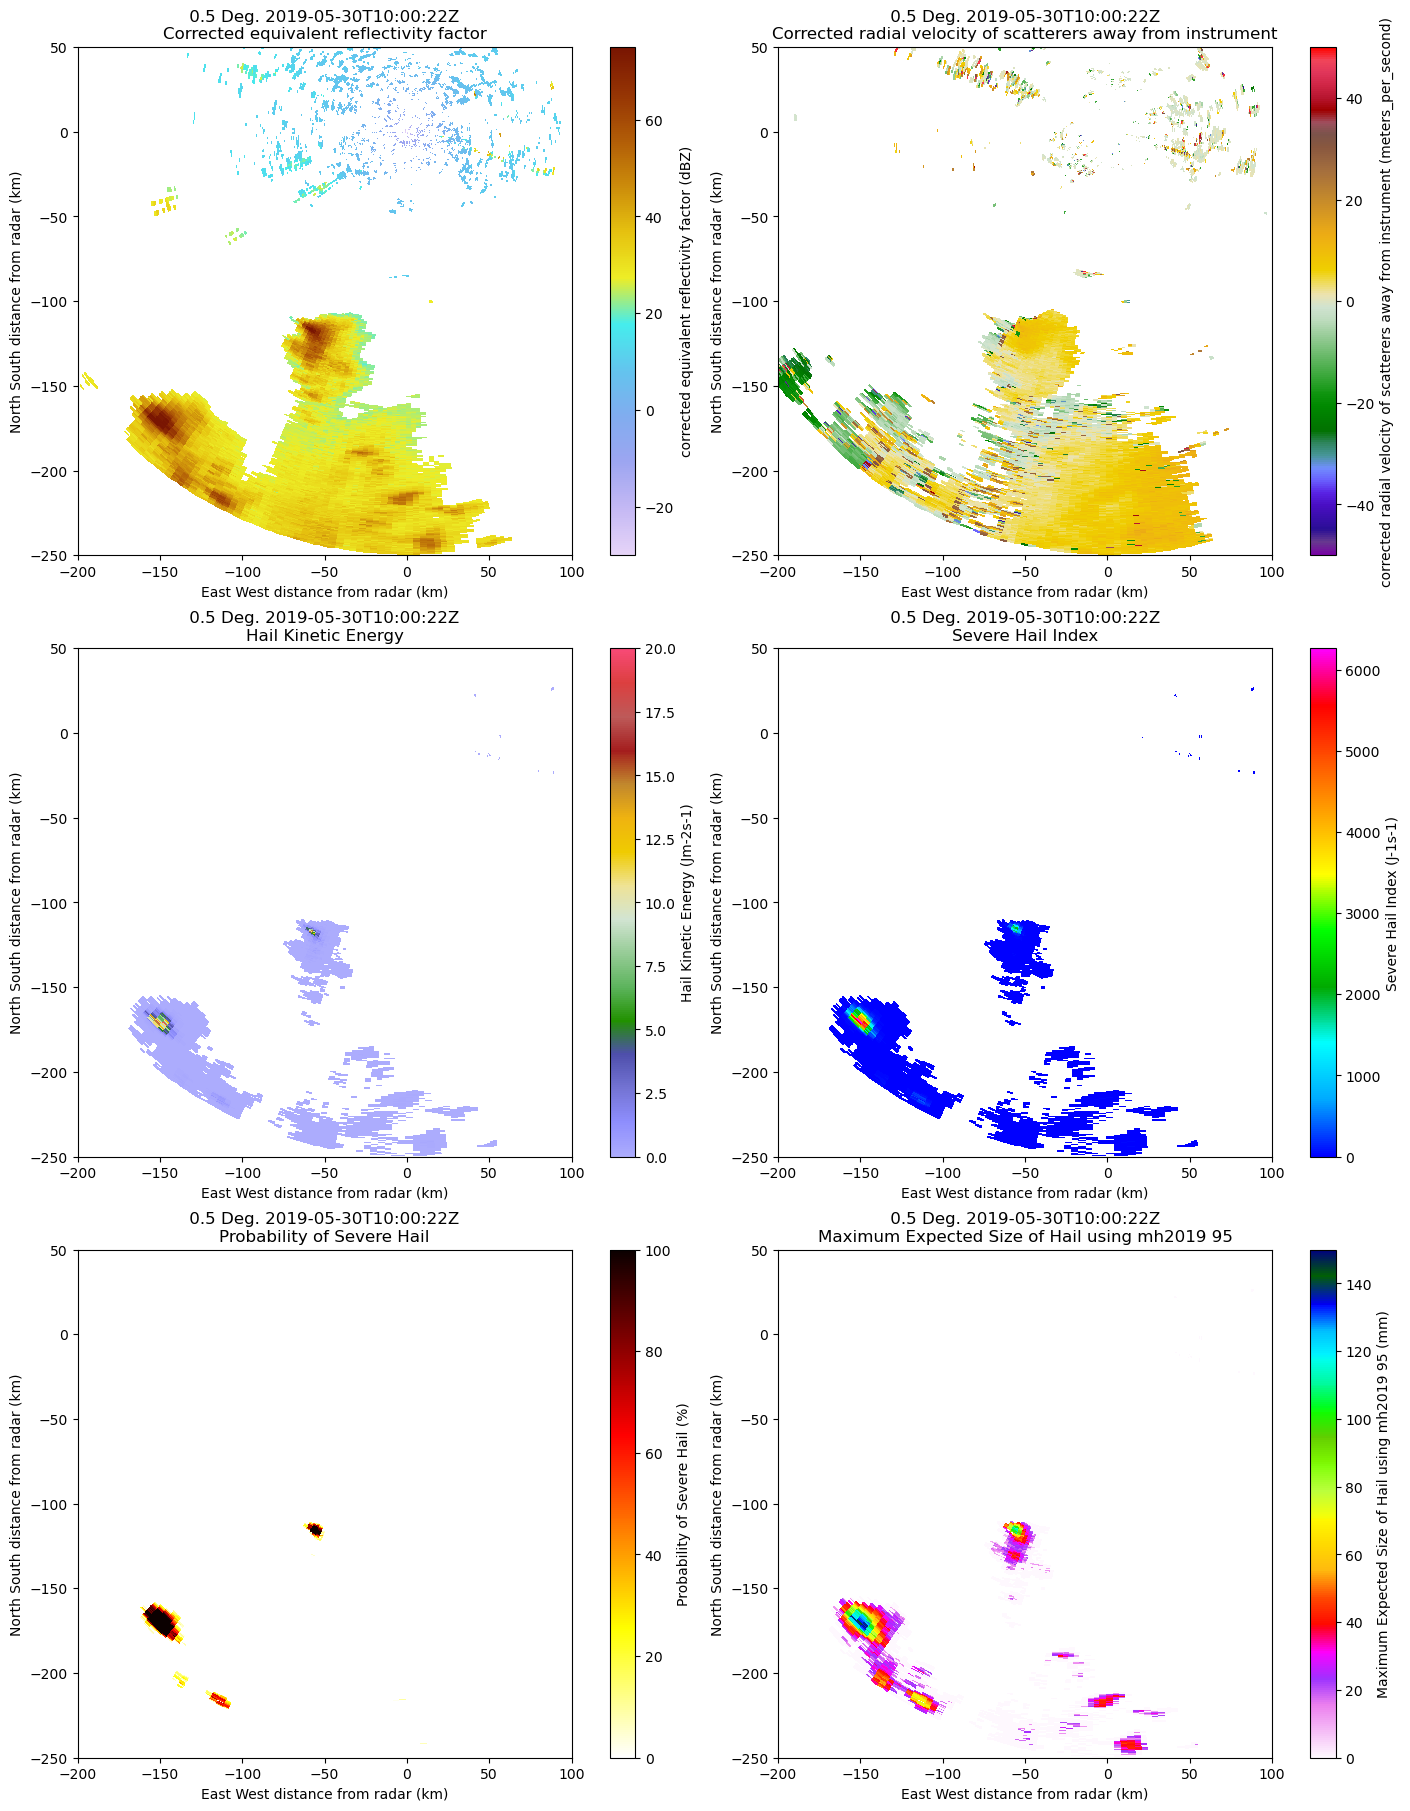

In [18]:
display = pyart.graph.RadarDisplay(radar)

gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_masked('hail_ke')

fig, axs = plt.subplots(3, 2, figsize = [14, 18], constrained_layout = True)

for ax in axs.ravel():
    ax.set_xlim(-200, 100)
    ax.set_ylim(-250, 50)

display.plot_ppi('corrected_reflectivity', 0, cmap = pyart.graph.cm.LangRainbow12, ax = axs.ravel()[0])
display.plot_ppi('corrected_velocity', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[1])
display.plot_ppi('hail_ke', 0, vmin = 0, vmax = 20, cmap = pyart.graph.cm.Theodore16, ax = axs.ravel()[2])
display.plot_ppi('shi', 0, cmap = pyart.graph.cm.RefDiff, ax = axs.ravel()[3], gatefilter=gatefilter)
display.plot_ppi('posh', 0, vmin = 0, vmax = 100, cmap = 'hot_r', ax = axs.ravel()[4], gatefilter=gatefilter)
display.plot_ppi('mesh_mh2019_95', 0, vmin = 0, vmax = 150, cmap = 'gist_ncar_r', ax = axs.ravel()[5], gatefilter=gatefilter)